In [1]:
'''
Notebook to explore the data generation and loading utils for MAML reproduction
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
# !pip3 install higher
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings

ax_size = 14
title_size = 16

In [2]:
'''
Create a master data class to ensure analogous structure across tasks
Help on writing abstract classes from: 
https://www.geeksforgeeks.org/abstract-classes-in-python/

Meta-train has training and test sets
Also have meta-val and meta-test sets (at the task level)
Help for understanding training and test set structure from [see especially for classification]: 
https://meta-learning.fastforwardlabs.com/


What do we want out of our data generation code? 
- specify a particular task instance
(e.g., amplitude and phase; N number of discrete classes)
- extract batches of tasks for train, val, and test
- extract sample from a given task of size K for training (and other for testing)
'''

class Domain(): 
    
    def get_meta_train_batch(self, task_batch_size):
        # yields the set of meta-training tasks, each of which has train and test sets
        pass 
    
    def get_meta_val_batch(self, task_batch_size):
        # yields meta-val tasks (each just has a single data set)
        pass

    def get_meta_test_batch(self, task_batch_size):
        # yields meta-test tasks (each just has a single data set)
        pass

In [3]:
'''
Regression task, as per MAML Section 5.1 (https://arxiv.org/pdf/1703.03400.pdf)
Specifically, sine wave generation 

Code inspired by and modified from: 
https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Checked original MAML code to ensure resampling for all stages of sinusoid:
https://github.com/cbfinn/maml/blob/master/data_generator.py
'''

class RegressionDomain(Domain): 
    
    '''
    Each task is a sine wave
    Parameterized by amplitude and phase 
    Always drawn from w/in a specified range of x vals
    [Values from Section 5.1 -- but we could vary??]
    '''
    
    def __init__(self, amp_min=0.1, amp_max=0.5, 
                 phase_min=0, phase_max=PI,
                train_size=1000, val_size=100, test_size=1000): 
        
        self.amp_min = amp_min
        self.amp_max = amp_max
        self.phase_min = phase_min
        self.phase_max = phase_max
        
        # create initial train, val, and test 
        # parameters specify the number of unique functions we want
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        # looping to instantiate tasks idea from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
        # help on generating random numbers in range from: https://pynative.com/python-get-random-float-numbers/
        self.tasks = {}
        # note: code would be more structured b/w task type for classification
        for task_type, num_tasks in zip(["train", "val", "test"], [train_size, val_size, test_size]):
            tasks = [SineFunction(amplitude = random.uniform(self.amp_min, self.amp_max), 
                                     phase=random.uniform(self.phase_min, self.phase_max)) for _ in range(num_tasks)]
            self.tasks[task_type] = tasks
    
    def get_batch_of_tasks(self, task_type, task_batch_size): 
        # helper function since same sampling per type for regression-specific domain
        if task_batch_size is None: 
            # return all 
            return self.tasks[task_type]
        else: 
            # sub-sample
            # note: we could investigate impact of weighted sub-sampling in batch (?)
            # see documentation: https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
            task_batch = np.random.choice(self.tasks[task_type], size=task_batch_size, replace=False)
            return task_batch
    
    def get_meta_train_batch(self, task_batch_size=10): 
        return self.get_batch_of_tasks("train", task_batch_size)
        
    def get_meta_val_batch(self, task_batch_size=None): 
        return self.get_batch_of_tasks("val", task_batch_size) 
        
    def get_meta_test_batch(self, task_batch_size=None): 
        return self.get_batch_of_tasks("test", task_batch_size)

        
class SineFunction(): 
    
    def __init__(self, amplitude, phase): 
        self.amplitude = amplitude
        self.phase = phase
        
    def draw_sample(self, x): 
        '''
        Sample from the specified sine wave 
        '''
        # help to sample from a sine function:
        # https://stackoverflow.com/questions/48043004/how-do-i-generate-a-sine-wave-using-python
        freq = 1 # TODO: check???
        return self.amplitude * np.sin(freq * x + self.phase)
    
    def get_samples(self, num_samples=10, 
                    min_query_x=-5.0, max_query_x=5.0): 
        '''
        Return samples drawn from this specific function (e.g., K for training set in meta-train)
        Note, input range uses values from paper (Section 5.1)
        But modification allowed thru function so we can test generalization beyond??
        '''
        x_vals = [random.uniform(min_query_x, max_query_x) for _ in range(num_samples)]
        y_vals = [self.draw_sample(x) for x in x_vals]
        # conversion to tensor idea and code help from: https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb
        return {"input": torch.Tensor(x_vals), "output": torch.Tensor(y_vals)}
        

In [8]:
#Set random seeds for reproducibility of results 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

#Neural Network Class that Ocariz wrote
class Neural_Network(nn.Module):
    def __init__(self, input_size=1, hidden_size=40, output_size=1):
        super(Neural_Network, self).__init__()
        # network layers
        self.hidden1 = nn.Linear(input_size,hidden_size)
        self.hidden2 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size,output_size)

        #Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output_layer(x)
        y = x
        return y

#Util functions that we have developed, not extensively used here

# The Minimum Square Error is used to evaluate the difference between prediction and ground truth
criterion = nn.MSELoss()

def copy_existing_model(model):
    # Function to copy an existing model
    # We initialize a new model
    new_model = Neural_Network()
    # Copy the previous model's parameters into the new model
    new_model.load_state_dict(model.state_dict())
    return new_model


def get_samples_in_good_format(wave, num_samples=10):
    #This function is used to sample data from a wave
    sample_data = wave.get_samples(num_samples=num_samples)
    x = sample_data["input"]
    y_true = sample_data["output"]
    # We add [:,None] to get the right dimensions to pass to the model: we want K x 1 (we have scalars inputs hence the x 1)
    # Note that we convert everything torch tensors
    x = torch.tensor(x[:,None])
    y_true = torch.tensor(y_true[:,None])
    # set to whatever the base device is (GPU or CPU)
    # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
    return x.to(device),y_true.to(device) 

def initialization_to_store_meta_losses():
  # This function creates lists to store the meta losses
  global store_train_loss_meta; store_train_loss_meta = []
  global store_test_loss_meta; store_test_loss_meta = []

def test_set_validation(model,new_model,wave,lr_inner,k,store_test_loss_meta):
    # This functions does not actually affect the main algorithm, it is just used to evaluate the new model
    new_model = training(model, wave, lr_inner, k)
    # Obtain the loss
    loss = evaluation(new_model, wave)
    # Store loss
    store_test_loss_meta.append(loss)

def train_set_evaluation(new_model,wave,store_train_loss_meta):
    loss = evaluation(new_model, wave)
    store_train_loss_meta.append(loss) 

def print_losses(epoch,store_train_loss_meta,store_test_loss_meta,printing_step=1000):
  if epoch % printing_step == 0:
    print(f'Epochh : {epoch}, Average Train Meta Loss : {np.mean(store_train_loss_meta)}, Average Test Meta Loss : {np.mean(store_test_loss_meta)}')

#This is based on the paper update rule, we calculate the difference between parameters and then this is used by the optimizer, rather than doing the update by hand
def reptile_parameter_update(model,new_model):
  # Zip models for the loop
  zip_models = zip(model.parameters(), new_model.parameters())
  for parameter, new_parameter in zip_models:
    if parameter.grad is None:
      parameter.grad = torch.tensor(torch.zeros_like(parameter))
    # Here we are adding the gradient that will later be used by the optimizer
    parameter.grad.data.add_(parameter.data - new_parameter.data)

# Define commands in order needed for the metaupdate
# Note that if we change the order it doesn't behave the same
def metaoptimizer_update(metaoptimizer):
  # Take step
  metaoptimizer.step()
  # Reset gradients
  metaoptimizer.zero_grad()

def metaupdate(model,new_model,metaoptimizer):
  # Combine the two previous functions into a single metaupdate function
  # First we calculate the gradients
  reptile_parameter_update(model,new_model)
  # Use those gradients in the optimizer
  metaoptimizer_update(metaoptimizer)

def evaluation(new_model, wave, num_samples=10):
    # Get data
    x, label = get_samples_in_good_format(wave,num_samples=num_samples)
    # Make model prediction
    prediction = new_model(x)
    # Get loss
    return criterion(prediction,label)

def training(model, wave, lr_k, k):
    # Create new model which we will train on
    new_model = copy_existing_model(model)
    # Define new optimizer
    koptimizer = torch.optim.SGD(new_model.parameters(), lr=lr_k)
    # Update the model multiple times, note that k>1 (do not confuse k with K)
    for i in range(k):
        # Reset optimizer
        koptimizer.zero_grad()
        # Evaluate the model
        loss = evaluation(new_model, wave, item = False)
        # Backpropagate
        loss.backward()
        koptimizer.step()
    return new_model

# for MAML -- see MAML cell for additional citations around structure inspiration
def task_specific_train_and_eval(model, T_i, inner_loop_optimizer, N=1, num_samples=10):
    #Description of the loop formulation from https://higher.readthedocs.io/en/latest/toplevel.html
    with innerloop_ctx(model, inner_loop_optimizer, copy_initial_weights = False) as (fmodel,diffopt):
        #get our input data and our label
        x, label = get_samples_in_good_format(T_i,num_samples=num_samples)
        per_step_loss = []
        for _ in range(N):
            #Get the task specific loss for our model
            task_specifc_loss = criterion(fmodel(x), label)

            #Step through the inner gradient
            diffopt.step(task_specifc_loss)
            
            per_step_loss.append(task_specifc_loss.item())
            
        held_out_task_specific_loss = evaluation(fmodel, T_i, num_samples=num_samples)
        
        return held_out_task_specific_loss, per_step_loss, fmodel

def plot_task_specific_train_and_eval(model, T_i, inner_loop_optimizer,K = 10, N=1, extract_task_info=False):
    
    '''
    if extract_task_info is True => return information on the initial task, and intermediate preds
    don't save for storage and compute reasons if set to False (by default)
    '''
    
    x, label = get_samples_in_good_format(T_i,num_samples=K)

    task_info = {}
    
    if extract_task_info == True: 
        input_coords = x.detach().numpy()[:,0]
        true_vals = sorted([(x, y) for (x, y) in zip(input_coords, label)], key=lambda x: x[0])
        
        task_info["input_coords"] = input_coords
        task_info["gt"] = true_vals
        
        # generate more points for a fine-grained evaluation of underlying func
        eval_x, eval_true_y = get_samples_in_good_format(T_i,num_samples=10000)
        
        eval_coords = eval_x.detach().numpy()[:,0]
        task_info["eval_coords"] = eval_coords
        task_info["gt_func"] = sorted([(x, y) for (x, y) in zip(eval_coords, eval_true_y)], key=lambda x: x[0])
        
    #Description of the loop formulation from https://higher.readthedocs.io/en/latest/toplevel.html
    with innerloop_ctx(model, inner_loop_optimizer, copy_initial_weights = False) as (fmodel,diffopt):
        #get our input data and our label
        per_step_loss = []
        for grad_step in range(N):
            
            preds = fmodel(x)
            #Get the task specific loss for our model
            task_specifc_loss = criterion(preds, label)

            #Step through the inner gradient
            diffopt.step(task_specifc_loss)
            
            per_step_loss.append(task_specifc_loss.item())
            
            if extract_task_info: 
                # use preds for new points
                preds_eval = fmodel(eval_x)
                task_preds = preds_eval.detach().numpy()[:,0]
                pred_data = sorted([(x, y) for (x, y) in zip(eval_coords, task_preds)], key=lambda x: x[0])
                task_info[f"preds_{grad_step}"] = pred_data
            
        held_out_task_specific_loss = evaluation(fmodel, T_i, num_samples=num_samples)
        
        return held_out_task_specific_loss, per_step_loss, fmodel, task_info

Available device: cpu


In [9]:
'''
Sample of how to use the classes
'''

# using parameters from original MAML Section 5.1 (https://arxiv.org/pdf/1703.03400.pdf)
amp_min=0.1
amp_max=5.0
phase_min=0
phase_max=PI
K = 10

# todo: check parameters we want
# specify the number of tasks to sample per meta-set
meta_train_size=1000
meta_val_size=100
meta_test_size=1000
meta_train_eval_size = 20

task_batch_size = 10  

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

meta_train_sample = dataset.get_meta_train_batch(task_batch_size=task_batch_size)

meta_train_sample[0].get_samples()

{'input': tensor([-2.7526,  0.7932, -4.7558,  3.1506, -0.7356,  2.3113, -4.7471,  2.9457,
          0.4840, -4.7807]),
 'output': tensor([-4.0844,  4.0920,  2.4892, -3.4754,  0.9901, -0.6023,  2.4597, -2.9328,
          4.1472,  2.5716])}

In [10]:
#The code includes extensive warnings when run so have used this to ignore them
warnings.filterwarnings("ignore")

In [11]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''


#Instantiate the model network
model = Neural_Network()
# move to the current device (GPU or CPU)
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
model.to(device)

T = 25 # num tasks
N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
num_samples = 10 # number of samples to draw from the task
lr_task_specific = 0.01 # task specific learning rate
lr_meta = 0.001 # meta-update learning rate
num_epochs = 10000#70001 #Number of iterations for outer loop
printing_step = 5000 # show log of loss every x epochs

#Used to store the validation losses
metaLosses = []
metaValLosses = []

#Meta-optimizer for the outer loop
meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

#Inner optimizer, we were doing this by hand previously
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

for epoch in range(num_epochs):
    # store loss over all tasks to then do a large meta-level update of initial params
    # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
    meta_loss = None
    
    #Sample a new wave each time
#     waves = [SineWaveTask() for _ in range(T)]
    waves = dataset.get_meta_train_batch(task_batch_size=T)
    
    #Loop through all of the tasks
    for i, T_i in enumerate(waves): 
        train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, N, num_samples=num_samples)
        held_out_task_specific_loss = train_eval_info[0]
        if meta_loss is None: 
            meta_loss = held_out_task_specific_loss
        else:
            meta_loss += held_out_task_specific_loss
            
    meta_optimizer.zero_grad()
    meta_loss /= T
    meta_loss.backward()
    meta_optimizer.step()
    metaLosses.append(meta_loss.item())
    
    # validation 
#     val_wave = SineWaveTask() # our own addition -- can vary
    val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
    val_train_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, N, num_samples=num_samples)
    val_loss = val_train_eval_info[0]
    metaValLosses.append(val_loss.item())
    
    if epoch % printing_step == 0:
        print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
        # saving model help from: 
        # https://pytorch.org/tutorials/beginner/saving_loading_models.html
        torch.save(model.state_dict(), "sample_maml_model.pt")

Iter =  0  Current Loss 4.321423530578613  Val Loss:  3.609294891357422
Iter =  5000  Current Loss 1.113980426553058  Val Loss:  1.2132595059796822


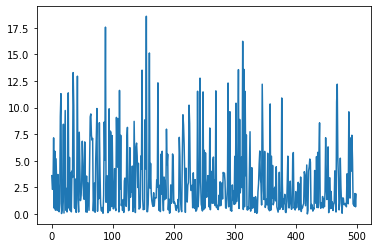

In [13]:
plt.plot(metaValLosses[:500])

(0.0, 10.0)

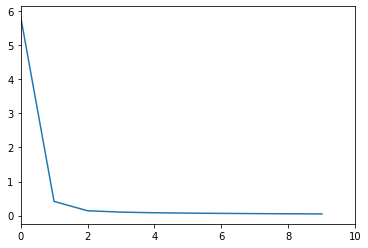

In [16]:
# run k-shot to check how rapidly we are able to adapt to unseen tasks
# starting w/ a single unseen task

# idea: re-run optimization per task multiple times to get a distribution over updates??
seed = 11
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

test_wave = dataset.get_meta_test_batch(task_batch_size=1)[0]#SineWaveTask()
num_k_shots = 10
extract_task_info = True

K = 10

# use model returned from earlier optimization
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
held_out_task_specific_loss, metaTrainLosses, _, task_info = plot_task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, K, num_k_shots, extract_task_info)

plt.plot(metaTrainLosses)
plt.xlim([0,num_k_shots])

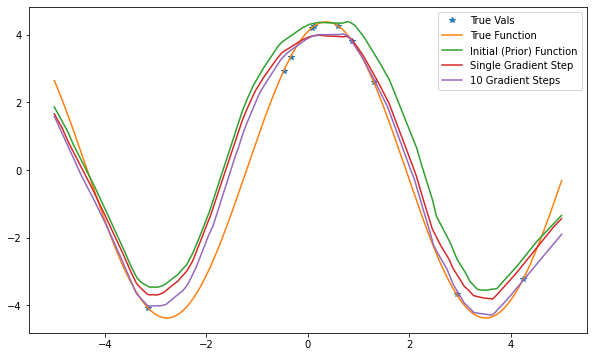

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax_size=16
title_size=18

true_vals = task_info["gt"]
func_gt = task_info["gt_func"]
func_prior = task_info["preds_0"]
updated_func_single = task_info["preds_1"]
updated_func_many = task_info[f"preds_{num_k_shots-1}"]

ax.plot(np.array(true_vals)[:,0], np.array(true_vals)[:,1], '*', label="True Vals")
ax.plot(np.array(func_gt)[:,0], np.array(func_gt)[:,1], label="True Function")
ax.plot(np.array(func_prior)[:,0], np.array(func_prior)[:,1], label="Initial (Prior) Function")
ax.plot(np.array(updated_func_single)[:,0], np.array(updated_func_single)[:,1], label="Single Gradient Step")
ax.plot(np.array(updated_func_many)[:,0], np.array(updated_func_many)[:,1], label=f"{num_k_shots} Gradient Steps")

ax.legend()

In [ ]:

fig, axes = plt.subplots(1,2, figsize=(12,6))
title=f"SARSA: Temporal Dynamics and Impact of Alpha and Discount Factor"
fig.suptitle(title, fontsize=title_size + 3)

ax=axes[0]
for idx, alg in enumerate(algs): 
    timesteps_per_episode = np.array(timesteps_per_alg[idx])

    y = np.mean(timesteps_per_episode, axis=0)
    x = list(range(len(y))) # episodes 
        
    ax.plot(x, y, linewidth=3, label=f"Mean Timesteps")
    
    # confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
    ci = 1.96 * np.std(timesteps_per_episode, axis=0)**2/np.sqrt(len(y))
    ax.fill_between(x, (y-ci), (y+ci), alpha=.5,label=f"95% CI")


ax.set_xlabel("Episodes",fontsize=ax_size)
ax.set_ylabel("Timesteps until Termination",fontsize=ax_size)
ax.set_title("Timesteps per Episode",fontsize=title_size)
ax.legend(loc="upper right")

ax.set_ylim([0,150])

ax = axes[1]
for gamma in gammas: 

    show_df = data_df
    show_df = show_df.loc[show_df["Gamma"] == gamma]

    errors = np.array([np.mean(x, axis=0) for x in np.array(show_df["RMSE Error"])])
    alphas = np.array(show_df["Alpha"])
    
    
    ax.plot(alphas, errors, label=f"Gamma = {gamma}")
    
    # confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
    ci = 1.96 * np.array([np.std(x, axis=0)**2 for x in np.array(show_df["RMSE Error"])])/np.sqrt(len(errors))
    ax.fill_between(alphas, (errors-ci), (errors+ci), alpha=.1)#,label=f"{alg} (95% CI)")


ax.set_xlabel("Alpha",fontsize=ax_size)
ax.set_ylabel("RMSE(V*, V)",fontsize=ax_size)
ax.set_title("Value Function RMSE vs. Alpha and Gamma",fontsize=title_size)
# ax.set_ylim([0,6])
ax.legend(loc="upper right")

plt.savefig("sarsa_hyperparams_lines.png",dpi=400, bbox_inches="tight")


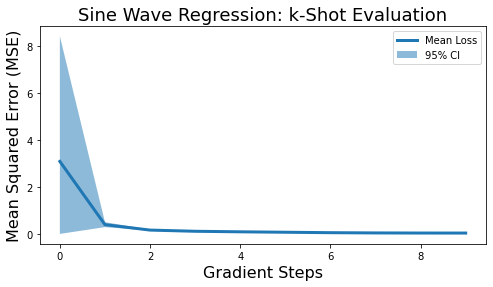

In [20]:
all_losses = []
num_eval = 100 
num_k_shots = 10

test_waves = dataset.get_meta_test_batch(task_batch_size=num_eval)
for test_eval in range(num_eval): 
    test_wave = test_waves[test_eval]

    # use model returned from earlier optimization
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
    held_out_task_specific_loss, metaTrainLosses, _ = task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, N=num_k_shots)

    all_losses.append(np.array(metaTrainLosses))

all_losses = np.array(all_losses)
np.save(f"maml_sine_{num_k_shots}.npy", all_losses)
    
fig, ax = plt.subplots(figsize=(8,4))

mean_loss = np.mean(all_losses, axis=0)

# confidence interval plotting help from: https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
y = mean_loss
x = list(range(num_k_shots))
ci = 1.96 * np.std(all_losses, axis=0)**2/np.sqrt(len(y))

ax_size=16
title_size=18
                                                  
ax.plot(x, y, linewidth=3, label=f"Mean Loss")
# to avoid having MSE < 0
truncated_error = np.clip(y-ci, a_min=0, a_max=None)
ax.fill_between(x, truncated_error, (y+ci), alpha=.5,label=f"95% CI")

ax.set_xlabel("Gradient Steps",fontsize=ax_size)
ax.set_ylabel("Mean Squared Error (MSE)",fontsize=ax_size)
ax.set_title("Sine Wave Regression: k-Shot Evaluation",fontsize=title_size)
ax.legend()#loc="upper right")
plt.savefig("sine_wave_reg_kshot.png")
# ax.set_ylim([0,7])

In [21]:
# run k-shot to check how rapidly we are able to adapt to unseen tasks
# starting w/ a single unseen task

# idea: re-run optimization per task multiple times to get a distribution over updates??
seed = 11
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

test_wave = dataset.get_meta_test_batch(task_batch_size=1)[0]#SineWaveTask()
num_k_shots = 10
extract_task_info = True

K = 10

# use model returned from earlier optimization
inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)
held_out_task_specific_loss, metaTrainLosses, _, task_info = plot_task_specific_train_and_eval(model, test_wave, inner_loop_optimizer, K, num_k_shots, extract_task_info)

plt.plot(metaTrainLosses)
plt.xlim([0,num_k_shots])

(100, 10)